If you want to run this colab please follow the instructions below

1. Download and upload the data from https://drive.google.com/drive/u/1/folders/1TcE9NNShm0irVqZM7y4Xtz7ibjHF9tAo to the colab (Data science project 2020/Data science project1/PM2.5_kaggle_2021)

2. Unzip the uploaded folder by typing the zip file name in cell 1 and rename foler after unzip to 'PM2.5_kaggle_2021'

3. Edit path in cell 3 to '/content/PM2.5_kaggle_2021'

In [29]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
import datetime
from math import pi

In [30]:
path = '/content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021'

# Prepare data

In [31]:
def combineDateTime(df):
    df['datetime'] = pd.to_datetime({'year': df['year'], 'month': df['month'], 'day':df['day'],'hour': df['UTC hour']})
    drop_columns = ['year', 'month', 'day', 'UTC hour']
    df = df.drop(drop_columns, axis=1)
    return df

def preparePM25(df):
    df = combineDateTime(df)
    df = df.drop(['PM10_mask', 'Retrospective'], axis=1)
    df = resampling(df, 1)
    return df

def prepareTempAndWind(file):
    df = pd.read_csv(os.path.join(path, file))
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.rename(columns={'Temp(C)': 'Temp'})
    df = resampling(df, 1)
    return df

def prepareFire():
    for country in ['Thailand', 'Cambodia', 'Lao_PDR', 'Myanmar']:
        dfs = []
        for year in ['2016', '2017', '2018', '2019']:
            df = pd.read_csv(os.path.join(path, 'Fire hotspot', 'viirs-snpp_' + year + '_' + country + '.csv'))
            dfs.append(df)
        df = pd.concat(dfs, axis=0, ignore_index=True)
        df['acq_time'] = roundup(df['acq_time'])
        df['acq_time'] = df['acq_time'].astype(str)
        df['datetime'] = pd.to_datetime(df['acq_date'] + df['acq_time'], format='%Y-%m-%d%H%M')
        df = changeTimezone(df)
        df['hotspot_count_' + country] = 1
        df = df[['hotspot_count_' + country]]
        df = df.groupby('datetime').agg({'hotspot_count_' + country: 'sum'})
        if country == 'Thailand':
            df_fire = df.copy()
        else:
            df_fire = df_fire.merge(df, left_index=True, right_index=True, how='outer')
    df_fire = df_fire.fillna(0)
    return df_fire

def prepareData(pm25, temp, wind, fire):
    df = pm25.merge(temp, left_index=True, right_index=True)
    df = df.merge(wind.drop(['lat', 'long'], axis=1), left_index=True, right_index=True)
    df = df.merge(fire, how='left', left_index=True, right_index=True)
    # df['latitude'].fillna(df['lat'], inplace=True)
    # df['longitude'].fillna(df['long'], inplace=True)
    # df['distance'] = distance(df['lat'], df['long'], df['latitude'], df['longitude'])
    # df['direction'] = direction(df['lat'], df['long'], df['latitude'], df['longitude'])
    # df['direction_diff'] = abs(df['direction'] - df['WindDir'])
    # df['bright_ti4'].fillna(0, inplace=True)
    # df['bright_ti5'].fillna(0, inplace=True)
    # df['frp'].fillna(0, inplace=True)
    for col in fire.columns:
        df[col] = df[col].fillna(0)
    df = df[~df.index.duplicated(keep='first')]
    df.index = pd.DatetimeIndex(df.index)
    return df

def changeTimezone(df):
    if type(df.index) is pd.core.indexes.datetimes.DatetimeIndex:
        df = df.reset_index('datetime')
    df['datetime'] = df['datetime'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
    df['datetime'] = df['datetime'].dt.tz_localize(None)
    df = addDay(df)

    df = df.set_index('datetime')
    return df

def addDay(df):
    if type(df.index) is pd.core.indexes.datetimes.DatetimeIndex:
        df = df.reset_index('datetime')
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['day_of_week'] = df['datetime'].dt.dayofweek
    return df

def resampling(df, hour):
    if not type(df.index) is pd.core.indexes.datetimes.DatetimeIndex:
        df = df.set_index('datetime')
    df = df.loc[~df.index.duplicated(keep='first')]
    df = df.resample(str(hour)+'H').interpolate(method='linear')
    return df

def distance(lat1, long1, lat2, long2):
    R = 6373.0
    lat1, long1, lat2, long2 = np.radians([lat1, long1, lat2, long2])
    a = np.sin((lat2-lat1)/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((long2-long1)/2.0)**2
    return R * 2 * np.arcsin(np.sqrt(a))
  
def direction(lat1, long1, lat2, long2):
    dir = np.arctan2(lat1-lat2, long1-long2)/pi * 180
    return dir + 360*(dir < 0)

def roundup(x):
    return ((np.ceil(x / 100.0)) * 100).astype(int)

def addPM25Lastyear(df):
    df_shift = df.shift(periods=24*365).rename(columns={'PM2.5': 'PM2.5_lastyear'})
    df = df.merge(df_shift['PM2.5_lastyear'], left_index=True, right_index=True)
    df['PM2.5_lastyear'].fillna(df['PM2.5'], inplace=True)
    return df

def addPM25LastyearForTest(df, df_train):
    df_all = df_train.drop(columns=['PM2.5_lastyear'], axis=1).append(df)
    df = addPM25Lastyear(df_all)
    df = df.iloc[df_train.shape[0]:]
    return df

## PM2.5 data

In [32]:
file = 'Bangkok/Train/Bangkok.txt'
bkk_pm25_train = pd.read_csv(os.path.join(path, file), delimiter = '\t', skiprows=10, header=None,
                names=['year', 'month', 'day', 'UTC hour', 'PM2.5', 'PM10_mask', 'Retrospective'])
bkk_pm25_train = preparePM25(bkk_pm25_train)
bkk_pm25_train = changeTimezone(bkk_pm25_train)
bkk_pm25_train = addDay(bkk_pm25_train)
bkk_pm25_train = bkk_pm25_train.set_index('datetime')
bkk_pm25_train.head(5)

,PM2.5,day_of_year,day_of_week
datetime,,,
2016-03-03 15:00:00,62.9,63,3
2016-03-03 16:00:00,62.9,63,3
2016-03-03 17:00:00,55.5,63,3
2016-03-03 18:00:00,55.5,63,3
2016-03-03 19:00:00,47.9,63,3


In [33]:
file = 'Bangkok/Test/Bangkok.csv'
bkk_pm25_test = pd.read_csv(os.path.join(path, file), skiprows=1,
                            names=['datetime', 'PM2.5'])
bkk_pm25_test['datetime'] = pd.to_datetime(bkk_pm25_test['datetime'])
bkk_pm25_test = addDay(bkk_pm25_test)
bkk_pm25_test = bkk_pm25_test.set_index('datetime')
bkk_pm25_test.head(5)

,PM2.5,day_of_year,day_of_week
datetime,,,
2019-03-18 08:00:00,45.6,77,0
2019-03-18 09:00:00,46.6,77,0
2019-03-18 10:00:00,47.7,77,0
2019-03-18 11:00:00,43.7,77,0
2019-03-18 12:00:00,41.6,77,0


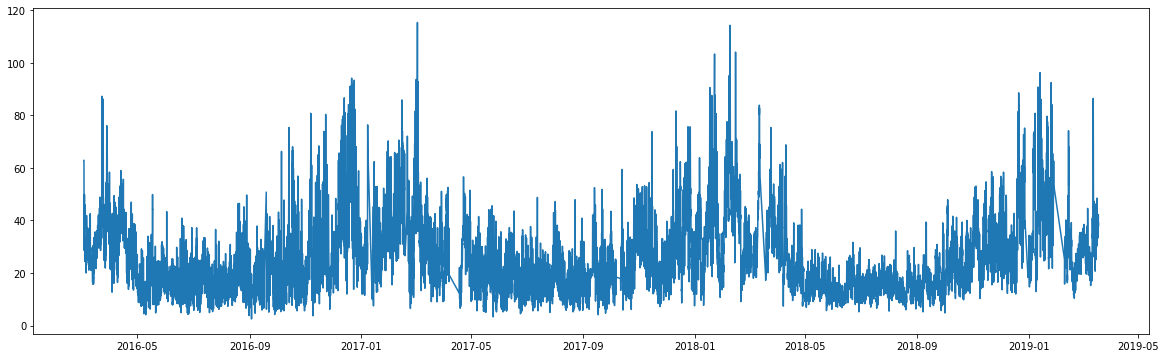

In [34]:
plt.figure(figsize=(20,6))
plt.plot(bkk_pm25_train['PM2.5'])
plt.show()

## Temperature data

In [35]:
bkk_temp_train = prepareTempAndWind('Bangkok/Train/3H_temperature_Bangkok.csv')
bkk_temp_train.head(5)

,Temp,lat,long
datetime,,,
2016-03-03 01:00:00,25.500000,13.754,100.5014
2016-03-03 02:00:00,25.333333,13.754,100.5014
2016-03-03 03:00:00,25.166667,13.754,100.5014
2016-03-03 04:00:00,25.000000,13.754,100.5014
2016-03-03 05:00:00,25.466667,13.754,100.5014


In [36]:
bkk_temp_test = prepareTempAndWind('Bangkok/Test/3H_temperature_Bangkok.csv')
bkk_temp_test.head(5)

,Temp,lat,long
datetime,,,
2019-03-18 01:00:00,29.200000,13.754,100.5014
2019-03-18 02:00:00,29.033333,13.754,100.5014
2019-03-18 03:00:00,28.866667,13.754,100.5014
2019-03-18 04:00:00,28.700000,13.754,100.5014
2019-03-18 05:00:00,28.900000,13.754,100.5014


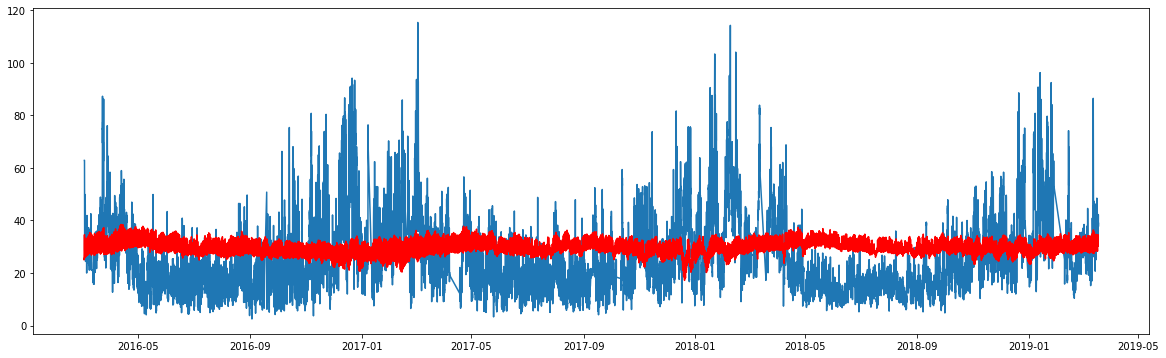

In [37]:
plt.figure(figsize=(20,6))
plt.plot(bkk_pm25_train['PM2.5'])
plt.plot(bkk_temp_train['Temp'], 'r')
plt.show()

## Wind data

In [38]:
bkk_wind_train = prepareTempAndWind('Bangkok/Train/3H_wind_Bangkok.csv')
bkk_wind_train.head(5)

,WindDir,Wind Speed(km/h),lat,long
datetime,,,,
2016-03-03 01:00:00,45.000000,13.000000,13.754,100.5014
2016-03-03 02:00:00,50.000000,12.333333,13.754,100.5014
2016-03-03 03:00:00,55.000000,11.666667,13.754,100.5014
2016-03-03 04:00:00,60.000000,11.000000,13.754,100.5014
2016-03-03 05:00:00,61.666667,12.333333,13.754,100.5014


In [39]:
bkk_wind_test = prepareTempAndWind('Bangkok/Test/3H_wind_Bangkok.csv')
bkk_wind_test.head(5)

,WindDir,Wind Speed(km/h),lat,long
datetime,,,,
2019-03-18 01:00:00,100.0,16.000000,13.754,100.5014
2019-03-18 02:00:00,105.0,16.000000,13.754,100.5014
2019-03-18 03:00:00,110.0,16.000000,13.754,100.5014
2019-03-18 04:00:00,115.0,16.000000,13.754,100.5014
2019-03-18 05:00:00,120.0,16.333333,13.754,100.5014


In [40]:
# plt.figure(figsize=(20,6))
# plt.plot(bkk_pm25_train['PM2.5'])
# plt.plot(bkk_wind_train['WindDir'], 'r')
# plt.plot(bkk_wind_train['Wind Speed(km/h)'], 'pink')
# plt.show()

## Fire data

In [41]:
fire = prepareFire()
fire.head(5)

,hotspot_count_Thailand,hotspot_count_Cambodia,hotspot_count_Lao_PDR,hotspot_count_Myanmar
datetime,,,,
2016-01-01 14:00:00,253.0,1861.0,46.0,173.0
2016-01-02 01:00:00,4.0,176.0,1.0,0.0
2016-01-02 03:00:00,62.0,104.0,3.0,33.0
2016-01-02 14:00:00,512.0,1447.0,114.0,137.0
2016-01-03 03:00:00,137.0,92.0,5.0,37.0


## Merge data

In [42]:
bkk_train = prepareData(bkk_pm25_train, bkk_temp_train, bkk_wind_train, fire)
bkk_train.head(5)

,PM2.5,day_of_year,day_of_week,Temp,lat,long,WindDir,Wind Speed(km/h),hotspot_count_Thailand,hotspot_count_Cambodia,hotspot_count_Lao_PDR,hotspot_count_Myanmar
datetime,,,,,,,,,,,,
2016-03-03 15:00:00,62.9,63,3,34.433333,13.754,100.5014,63.333333,12.000000,214.0,0.0,0.0,718.0
2016-03-03 16:00:00,62.9,63,3,34.600000,13.754,100.5014,60.000000,12.000000,0.0,0.0,0.0,0.0
2016-03-03 17:00:00,55.5,63,3,32.766667,13.754,100.5014,63.333333,11.666667,0.0,0.0,0.0,0.0
2016-03-03 18:00:00,55.5,63,3,30.933333,13.754,100.5014,66.666667,11.333333,0.0,0.0,0.0,0.0
2016-03-03 19:00:00,47.9,63,3,29.100000,13.754,100.5014,70.000000,11.000000,0.0,0.0,0.0,0.0


In [43]:
# bkk_train.describe()

In [44]:
# plt.figure(figsize=(20,6))
# plt.plot(bkk_train)
# plt.show()

In [45]:
bkk_test = prepareData(bkk_pm25_test, bkk_temp_test, bkk_wind_test, fire)
bkk_test.head(5)

,PM2.5,day_of_year,day_of_week,Temp,lat,long,WindDir,Wind Speed(km/h),hotspot_count_Thailand,hotspot_count_Cambodia,hotspot_count_Lao_PDR,hotspot_count_Myanmar
datetime,,,,,,,,,,,,
2019-03-18 08:00:00,45.6,77,0,30.666667,13.754,100.5014,126.666667,16.0,0.0,0.0,0.0,0.0
2019-03-18 09:00:00,46.6,77,0,32.033333,13.754,100.5014,123.333333,15.0,0.0,0.0,0.0,0.0
2019-03-18 10:00:00,47.7,77,0,33.400000,13.754,100.5014,120.000000,14.0,0.0,0.0,0.0,0.0
2019-03-18 11:00:00,43.7,77,0,33.766667,13.754,100.5014,118.333333,14.0,0.0,0.0,0.0,0.0
2019-03-18 12:00:00,41.6,77,0,34.133333,13.754,100.5014,116.666667,14.0,0.0,0.0,0.0,0.0


In [46]:
# plt.figure(figsize=(20,6))
# plt.plot(bkk_train['PM2.5']/max(bkk_train['PM2.5']))
# plt.plot(bkk_train['hotspot_count']/max(bkk_train['hotspot_count']))
# plt.show()

## Add last year PM2.5 column

In [47]:
bkk_train = addPM25Lastyear(bkk_train)
bkk_train.head(5)

,PM2.5,day_of_year,day_of_week,Temp,lat,long,WindDir,Wind Speed(km/h),hotspot_count_Thailand,hotspot_count_Cambodia,hotspot_count_Lao_PDR,hotspot_count_Myanmar,PM2.5_lastyear
datetime,,,,,,,,,,,,,
2016-03-03 15:00:00,62.9,63,3,34.433333,13.754,100.5014,63.333333,12.000000,214.0,0.0,0.0,718.0,62.9
2016-03-03 16:00:00,62.9,63,3,34.600000,13.754,100.5014,60.000000,12.000000,0.0,0.0,0.0,0.0,62.9
2016-03-03 17:00:00,55.5,63,3,32.766667,13.754,100.5014,63.333333,11.666667,0.0,0.0,0.0,0.0,55.5
2016-03-03 18:00:00,55.5,63,3,30.933333,13.754,100.5014,66.666667,11.333333,0.0,0.0,0.0,0.0,55.5
2016-03-03 19:00:00,47.9,63,3,29.100000,13.754,100.5014,70.000000,11.000000,0.0,0.0,0.0,0.0,47.9


In [48]:
# bkk_train.describe()

In [49]:
bkk_test = addPM25LastyearForTest(bkk_test, bkk_train)
bkk_test

,PM2.5,day_of_year,day_of_week,Temp,lat,long,WindDir,Wind Speed(km/h),hotspot_count_Thailand,hotspot_count_Cambodia,hotspot_count_Lao_PDR,hotspot_count_Myanmar,PM2.5_lastyear
datetime,,,,,,,,,,,,,
2019-03-18 08:00:00,45.6,77,0,30.666667,13.754,100.5014,126.666667,16.000000,0.0,0.0,0.0,0.0,26.40
2019-03-18 09:00:00,46.6,77,0,32.033333,13.754,100.5014,123.333333,15.000000,0.0,0.0,0.0,0.0,26.14
2019-03-18 10:00:00,47.7,77,0,33.400000,13.754,100.5014,120.000000,14.000000,0.0,0.0,0.0,0.0,25.88
2019-03-18 11:00:00,43.7,77,0,33.766667,13.754,100.5014,118.333333,14.000000,0.0,0.0,0.0,0.0,25.62
2019-03-18 12:00:00,41.6,77,0,34.133333,13.754,100.5014,116.666667,14.000000,0.0,0.0,0.0,0.0,25.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-18 16:00:00,23.9,78,2,33.000000,13.754,100.5014,210.000000,7.000000,0.0,0.0,0.0,0.0,32.70
2020-03-18 17:00:00,24.4,78,2,32.133333,13.754,100.5014,226.666667,6.666667,0.0,0.0,0.0,0.0,29.40
2020-03-18 18:00:00,24.9,78,2,31.266667,13.754,100.5014,243.333333,6.333333,0.0,0.0,0.0,0.0,32.60


In [50]:
# plt.figure(figsize=(20,6))
# plt.plot(bkk_train['PM2.5_lastyear'], 'r')
# plt.plot(bkk_train['PM2.5'])
# plt.show()

In [51]:
# plt.figure(figsize=(20,6))
# plt.plot(bkk_test['PM2.5_lastyear'], 'r')
# plt.plot(bkk_test['PM2.5'])
# plt.show()

## Prepare data

In [52]:
def load_data(df, n_in=1, n_out=72, features=['PM2.5']):
    n_features = len(features)
    data = df[features].to_numpy()
    X = []
    y = []
    for i in range(len(data)-n_in-n_out):
        X.append(data[i: i+n_in+2])
        temp = []
        for j in range(i+n_in+1, i+n_in+1 + n_out):
            temp.append(data[j][0])
        y.append(temp)
    X = np.array(X)
    y = np.array(y)
    X = X[:, :-1]
    return X, y

def load_data_test(df, df_train, n_in=1, n_out=72, features=['PM2.5']):
    df_all = df_train.append(df)
    X, y = load_data(df_all, n_in, n_out, features=features)
    X, y = X[df_train.shape[0]-n_in+4::6], y[df_train.shape[0]-n_in+4::6]
    return X, y

In [53]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def normalize(df_train, df_test):
    scaler_dict = dict()
    for col in [col for col in df_train.columns if col != 'PM2.5' and col != 'PM2.5_lastyear']:
        scaler = MinMaxScaler()
        df_train[col] = scaler.fit_transform(df_train[col].values.reshape(-1,1))
        scaler_dict[col] = scaler
    
    for col in [col for col in df_test.columns if col != 'PM2.5' and col != 'PM2.5_lastyear']:
        df_test[col] = scaler_dict[col].transform(df_test[col].values.reshape(-1,1))
      
    scaler = MinMaxScaler()
    df_train['PM2.5'] = scaler.fit_transform(df_train[['PM2.5']])
    df_train['PM2.5_lastyear'] = scaler.transform(df_train[['PM2.5_lastyear']])
    df_test['PM2.5'] = scaler.transform(df_test[['PM2.5']])
    df_test['PM2.5_lastyear'] = scaler.transform(df_test[['PM2.5_lastyear']])
    return df_train, df_test, scaler

In [62]:
features = ['PM2.5', 'PM2.5_lastyear', 'day_of_year', 'day_of_week', 'Temp', 
            'hotspot_count_Thailand']
# features = ['PM2.5', 'PM2.5_lastyear', 'day_of_year',	'day_of_week', 'Temp', 'Wind Speed(km/h)', 'bright_ti4', 'bright_ti5', 'frp', 'hotspot_count', 'distance', 'direction_diff']
prev_hour = 3
n_features = len(features)
X_train, y_train = load_data(bkk_train, n_in=prev_hour, features=features)
print(X_train[0])
print(y_train[0])
print(X_train.shape, y_train.shape)

[[ 62.9         62.9         63.           3.          34.43333333
  214.        ]
 [ 62.9         62.9         63.           3.          34.6
    0.        ]
 [ 55.5         55.5         63.           3.          32.76666667
    0.        ]
 [ 55.5         55.5         63.           3.          30.93333333
    0.        ]]
[47.9 43.6 28.6 33.6 34.8 31.3 36.7 42.1 38.6 45.5 49.9 44.1 42.1 43.1
 44.8 37.5 39.6 46.  43.8 36.6 34.2 35.  30.  25.6 32.1 24.4 32.8 32.9
 30.7 29.2 28.1 33.3 33.3 33.3 33.3 33.3 33.3 33.3 33.3 33.3 33.3 33.3
 33.3 33.3 33.3 33.3 33.3 33.3 33.3 33.3 33.3 33.3 33.3 33.8 20.  24.3
 26.3 25.9 25.5 28.9 24.  24.1 25.2 23.8 27.1 41.9 41.  39.5 35.3 34.1
 30.9 27.6]
(26549, 4, 6) (26549, 72)


In [61]:
X_test, y_test = load_data_test(bkk_test, bkk_train, n_in=prev_hour, features=features)
print(X_test[0])
print(y_test[0])

[[46.6        26.14       77.          0.         32.03333333  0.        ]
 [47.7        25.88       77.          0.         33.4         0.        ]
 [43.7        25.62       77.          0.         33.76666667  0.        ]
 [41.6        25.36       77.          0.         34.13333333  0.        ]]
[42.1 42.1 40.  39.8 43.  40.4 38.  36.6 34.8 32.7 33.9 33.1 33.1 32.2
 30.8 28.9 30.8 31.3 32.9 36.1 37.9 40.8 35.6 31.9 31.6 30.3 30.6 32.7
 29.4 32.6 34.5 33.  33.  32.7 33.5 34.9 33.5 33.2 32.6 31.1 29.9 30.1
 29.8 32.8 33.3 35.1 36.5 32.5 34.3 33.1 32.1 30.7 28.6 30.  26.4 26.6
  0.  28.8  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0. ]


In [65]:
bkk_test.head(7)

,PM2.5,day_of_year,day_of_week,Temp,lat,long,WindDir,Wind Speed(km/h),hotspot_count_Thailand,hotspot_count_Cambodia,hotspot_count_Lao_PDR,hotspot_count_Myanmar,PM2.5_lastyear
datetime,,,,,,,,,,,,,
2019-03-18 08:00:00,45.6,77,0,30.666667,13.754,100.5014,126.666667,16.000000,0.0,0.0,0.0,0.0,26.40
2019-03-18 09:00:00,46.6,77,0,32.033333,13.754,100.5014,123.333333,15.000000,0.0,0.0,0.0,0.0,26.14
2019-03-18 10:00:00,47.7,77,0,33.400000,13.754,100.5014,120.000000,14.000000,0.0,0.0,0.0,0.0,25.88
2019-03-18 11:00:00,43.7,77,0,33.766667,13.754,100.5014,118.333333,14.000000,0.0,0.0,0.0,0.0,25.62
2019-03-18 12:00:00,41.6,77,0,34.133333,13.754,100.5014,116.666667,14.000000,0.0,0.0,0.0,0.0,25.36
2019-03-18 13:00:00,42.1,77,0,34.500000,13.754,100.5014,115.000000,14.000000,79.0,582.0,939.0,100.0,25.10
2019-03-18 14:00:00,42.1,77,0,34.500000,13.754,100.5014,113.333333,13.666667,0.0,0.0,0.0,0.0,24.84
